In [415]:
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

%matplotlib inline

In [416]:
# Set True if you want to trace the parsing process
trace_parsing = False

In [427]:
def read_model_file(filename, trace_pasing):
    coords = np.empty((0, 3))
    with open(filename) as f:
        line = f.readline()
        model_to_coords = {}
        current_model = -1
        while line:
            words = line.strip().split(' ')
            if len(words) > 0:
                if words[0] == "MODEL":
                    current_model = words[1]
                    if trace_parsing:
                        print("Current models is: MODEL", current_model)
                elif words[0] == "ATOM":
                    if current_model == -1:
                        raise NameError('Unkown model with MODEL={current_model}')
                    x, y, z = 0, 0, 0
                    coord_starts = [6, 7, 8]
                    last_nonempty = 0
                    for idx, word in enumerate(words):
                        if len(word.strip()) > 0:
                            last_nonempty += 1
                            if last_nonempty == coord_starts[0]:
                                x = word
                            elif last_nonempty == coord_starts[1]:
                                y = word
                            elif last_nonempty == coord_starts[2]:
                                z = word
                    current_model_coords = np.array([[x, y, z]])
                    if trace_parsing:
                        print(f'Atom coords for MODEL={current_model} is {current_model_coords}')
                    coords = np.append(coords, current_model_coords, axis=0)
                elif words[0] == "ENDMDL":
#                     print(f'coords.shape = {coords.shape}')
                    model_to_coords[int(current_model)] = coords.astype(np.float64)
                    if trace_parsing:
                        print(f'Finished MODEL={current_model}')
                    current_model = -1
            line = f.readline()
    return model_to_coords

In [428]:
def read_reslog_file(filename):
    model_to_use = []
    with open(filename) as f:
        line = f.readline()
        while line:
            words = [w for w in line.strip().split(' ') if w]
            if len(words) == 4:
                if float(words[2]) <= 2.0:
                    model_to_use.append(int(words[0]))
            line = f.readline()
    return model_to_use

In [429]:
def calculate_model_mean(model):
    return np.mean(model, axis=0, dtype=np.float64).reshape(1, 3)

In [430]:
def calculate_centers(rootdir):
    centers = np.empty((0, 3))
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    for subdir, dirs, filenames in os.walk(rootdir):
        if subdir == rootdir:
            continue
            
        print("===")
        
        reslog = os.path.join(subdir, [f for f in filenames if f.endswith(".log")][0])
        pdbqt = os.path.join(subdir, [f for f in filenames if f.endswith(".pdbqt")][0])
        print(f'Current directory is "{subdir}"')
        print(f'Current reslog file is "{reslog}"')
        print(f'Current model file is "{pdbqt}"')

        model_keys_to_use = read_reslog_file(reslog)
        print(f'Following models will be used {model_keys_to_use}')
        
        models_all = read_model_file(pdbqt, trace_parsing)
        models_to_use = dictfilt(models_all, model_keys_to_use)
        for model in models_to_use.values():
#             print(f'model.shape={model.shape}')
#             print(f'model.mean={calculate_model_mean(model)}')
            centers = np.append(centers, calculate_model_mean(model), axis=0)
#             print(f'centers.shape={centers.shape}')
        print("===")
        
    return centers

In [453]:
models = calculate_centers("./data/")

===
Current directory is "./data/3"
Current reslog file is "./data/3/res.log"
Current model file is "./data/3/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 9]
===
===
Current directory is "./data/2"
Current reslog file is "./data/2/res.log"
Current model file is "./data/2/Str-2 3D_out.pdbqt"
Following models will be used [1, 8]
===
===
Current directory is "./data/1"
Current reslog file is "./data/1/res.log"
Current model file is "./data/1/Str-2_3D_out.pdbqt"
Following models will be used [1, 5, 9]
===
===
Current directory is "./data/5"
Current reslog file is "./data/5/res.log"
Current model file is "./data/5/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9]
===
===
Current directory is "./data/4"
Current reslog file is "./data/4/res.log"
Current model file is "./data/4/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9]
===


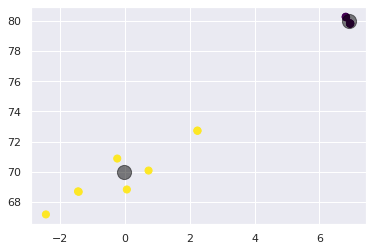

In [473]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(models)
y_kmeans = kmeans.predict(models)

plt.scatter(models[:, 0], models[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);

In [461]:
models.shape

(16, 3)

In [462]:
centers.shape

(4, 3)